<a href="https://colab.research.google.com/github/alefram/notebooks/blob/master/pokedex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokedex using CNN

## Colab setup

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.

## Import Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import PIL
import random
import pathlib
import datetime
import PIL.Image

import numpy as np
import matplotlib.pyplot as plt

from IPython import display

from datasets import load_dataset

# Data Setup

In [3]:
#Download data
ds = load_dataset("fcakyon/pokemon-classification", name="full")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/4869 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1390 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/732 [00:00<?, ? examples/s]

In [4]:
# Usefull methods
def visualize_pokemons(images, labels, class_names):
    plt.figure(figsize=(10, 5))

    random_indices = np.random.choice(len(images), size=18, replace=False)

    for i, idx in enumerate(random_indices):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[idx].numpy().transpose((1, 2, 0)))
        plt.title(class_names[labels[idx]])
        plt.axis("off")

In [5]:
# Define data
ds = ds.with_format("torch")
train_ds = ds['train']
test_ds = ds['test']
val_ds =  ds['validation']
class_names = train_ds.features['labels'].names

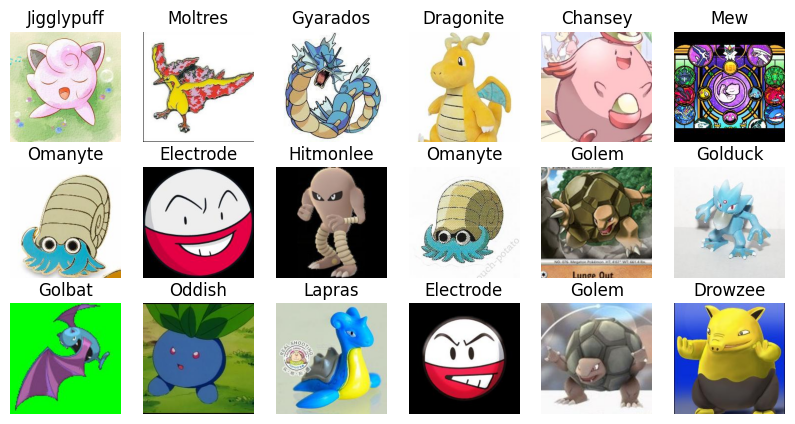

In [6]:
#visualize data
visualize_pokemons(
    images=train_ds['image'],
    labels=train_ds['labels'],
    class_names=class_names
)

# Training

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [107]:
# Define neural network
class PokemonCNN(nn.Module):
    def __init__(self, ch_in, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(ch_in, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128*14*14, 510)
        self.fc2 = nn.Linear(510, num_classes)

        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.2)
        self.dropout3 = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.dropout2(x)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = self.dropout3(x)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        x = torch.flatten(x,1)

        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x))

        return x
# class PokemonCNN(nn.Module):
#     def __init__(self, ch_in, num_classes):
#         super(PokemonCNN, self).__init__()

#         def conv_bn(inp, oup, stride):
#             return nn.Sequential(
#                 nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
#                 nn.BatchNorm2d(oup),
#                 nn.ReLU(inplace=True)
#                 )

#         def conv_dw(inp, oup, stride):
#             return nn.Sequential(
#                 # dw
#                 nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
#                 nn.BatchNorm2d(inp),
#                 nn.ReLU(inplace=True),

#                 # pw
#                 nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
#                 nn.BatchNorm2d(oup),
#                 nn.ReLU(inplace=True),
#                 )

#         self.model = nn.Sequential(
#             conv_bn(ch_in, 32, 2),
#             conv_dw(32, 64, 1),
#             conv_dw(64, 128, 2),
#             conv_dw(128, 128, 1),
#             conv_dw(128, 256, 2),
#             conv_dw(256, 256, 1),
#             conv_dw(256, 512, 2),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 512, 1),
#             conv_dw(512, 1024, 2),
#             nn.Dropout(p=0.2),
#             conv_dw(1024, 1024, 1),
#             nn.AdaptiveAvgPool2d(1)
#         )
#         self.fc = nn.Sequential(
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.2),
#             nn.Linear(512, num_classes)
#         )
#     def forward(self, x):
#         x = self.model(x)
#         x = torch.flatten(x,1)
#         x = self.fc(x)
#         return x

model = PokemonCNN(ch_in=3, num_classes=len(class_names)).to(device)

# print(model)

In [108]:
#Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

[EPOCH: 9, [TRAIN LOSS]: 0.150844, [VAL LOSS]: 63.016383


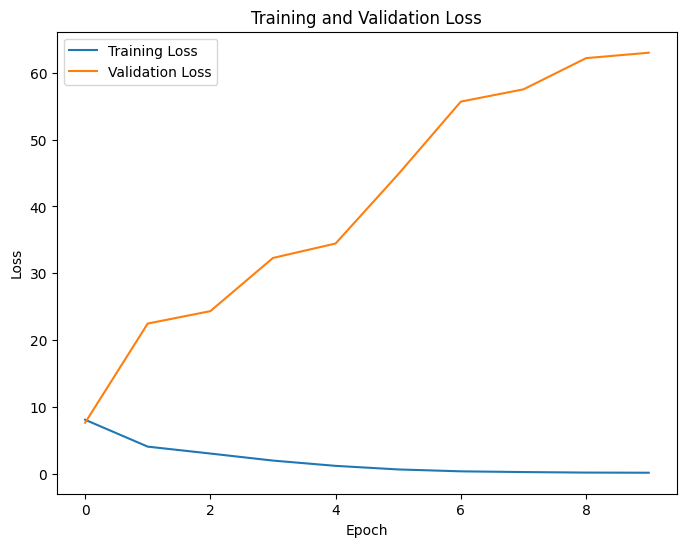

In [109]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)  # Assuming you have a validation dataset
epochs = 10

train_losses = []
val_losses = []

model.train(True)
for epoch in range(epochs):
    epoch_train_loss = 0
    for idx, batch in enumerate(train_loader):
      #feedforward
      images = batch['image'].to(device=device, dtype=torch.float32)
      labels = batch['labels'].to(device)

      y_pred = model(images)

      #compute loss accuracy
      y = labels
      loss = criterion(y_pred, y)
      epoch_train_loss += loss.item()
      score, predicted = torch.max(y_pred, 1)
      acc = (y == predicted).sum().float() / len(y)
      print("[EPOCH: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (epoch, loss.item(), acc))
      display.clear_output(wait=True)

      #backward
      optimizer.zero_grad()
      loss.backward()

      #update params
      optimizer.step()

    # Calculate average training loss for the epoch
    train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
      for batch in val_loader:
        images = batch['image'].to(device=device, dtype=torch.float32)
        labels = batch['labels'].to(device)

        y_pred = model(images)
        y = labels
        loss = criterion(y_pred, y)
        epoch_val_loss += loss.item()

    val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(val_loss)

    print(f"[EPOCH: {epoch}, [TRAIN LOSS]: {train_loss:.6f}, [VAL LOSS]: {val_loss:.6f}")

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluation

pokemon name:  Slowpoke label:  102


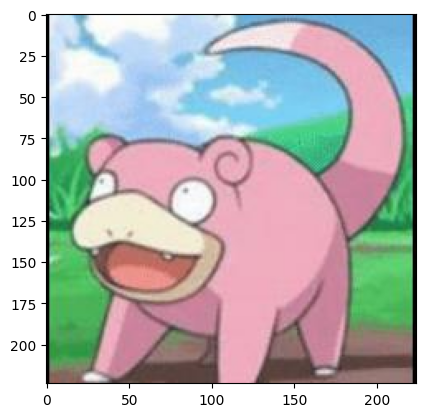

In [ ]:
n = 400
image = test_ds['image'][n]
label =  test_ds['labels'][n]
print("pokemon name: ", class_names[label], "label: ", label)

plt.imshow(image.astype("uint8"))

In [ ]:
#TODO: test model

This image most likely belongs to Dewgong with a 1.79 percent confidence.
